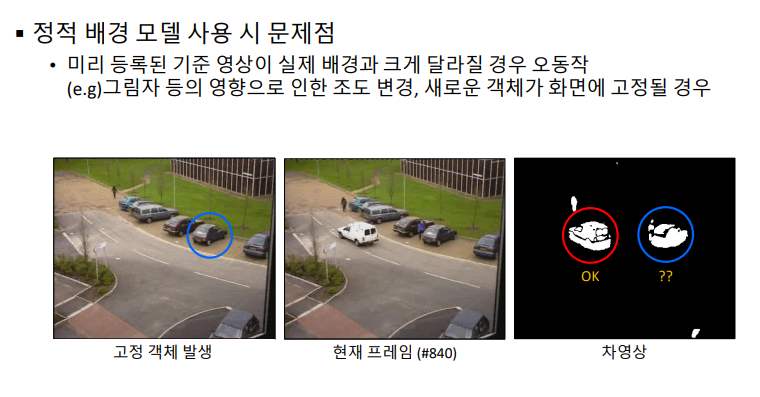
배경이 크게 바뀌면 처음의 배경영상을 쓸수 없다는 문제가 있었습니다. 만약 중간에 고정객체가 발생한다면 이것을 새로운 객체로 봐야할지 배경으로 봐야할지 판단이 필요하기 때문입니다.

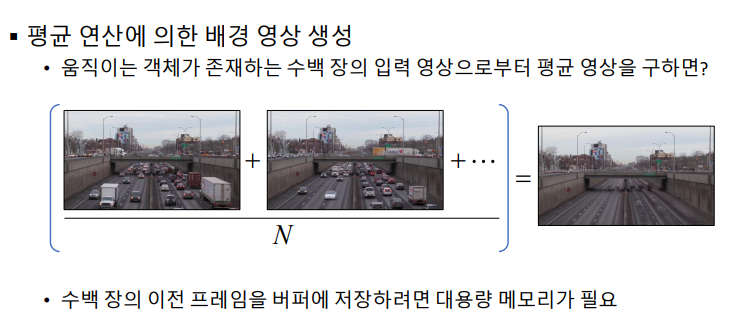
따라서 평균 연산을 한두장이 아니라 과거 수백장으로 평균을 냅니다.  
도로의 자동차들은 잠깐 들어왔다가 나가는 것들입니다.  
그래서 수백장의 영상, 약 10초정도의 300프레임을 저장해도 자동차가 하나도 없는 영상을 만들 수 있죠. 하지만 문제점은 수백장을 버퍼에 저장하면 FullHD만해도 2MB인데 수백장을 미리 저장하는 것이 메모리적으로 부담이 될 수 있습니다.

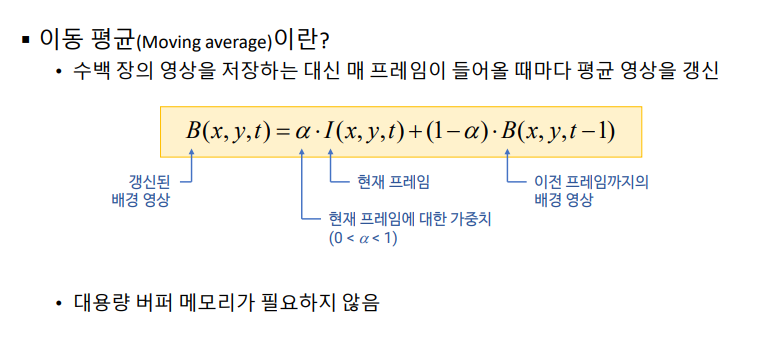
그래서 그 단점을 보완하기 위해 이동 평균을 사용합니다. 이 방법은 과거의 수백장을 다 저장하는것이 아니라, 새로운 프레임이 하나씩 들어올 때마다 배경영상을 업데이트 해줍니다. 즉, 가중합을 하는 것인데, I는 현재프레임, B는 배경영상, 그리고 가중치 합을 이용해서 배경영상을 업데이트 하는 것이죠. t는 시간축인데, t-1은 이전프레임이며, t는 현재 프레임입니다. 그래서 수백장을 미리 저장하는 것이 아니라 매 프레임을 조금씩 저장합니다. 따라서 배경영상은 미세하게 업데이트가 되므로 실수형 자료형을 사용해서 업데이트를 해 주어야 합니다.

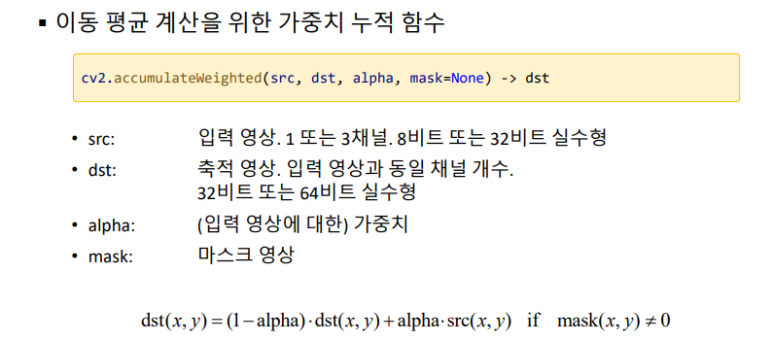
이 함수는 weight가 있는데 누적을 해줍니다. 가중치를 지정하면서 행렬을 누적할 수 있습니다. 

In [4]:
import sys 
import numpy as np 
import cv2 
import matplotlib.pyplot as plt 
import random 
!pip install opencv-python

In [5]:
cap = cv2.VideoCapture(0)


if not cap.isOpened():

    print('Video open failed!')

    sys.exit()

In [6]:
ret, back = cap.read()

#첫번째 프레임을 배경으로 등록한다.

if not ret:

    print('Background image registration failed!')

    sys.exit()


# back: uint8 배경, fback: float32 배경

back = cv2.cvtColor(back, cv2.COLOR_BGR2GRAY)

back = cv2.GaussianBlur(back, (0, 0), 1.0)

fback을 계속해서 업데이트 시켜줄 것입니다.

In [7]:
fback = back.astype(np.float32)

이전프레임에 99% 현재프레임에 1%의 가중치를 줍니다.

In [ ]:
while True:

    ret, frame = cap.read()


    if not ret:

        break

    
    #배경영상을 그레이와 가우시안블러로 노이즈를 제거해 줍니다.
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    gray = cv2.GaussianBlur(gray, (0, 0), 1.0)



    # fback: float32, back: uint8 배경

    cv2.accumulateWeighted(gray, fback, 0.01) 

#현재프레임에 가중치 0.01 배경에 99, 0.01도 작은게 아니다 3초면면 1이되기때문
#이것을 fback에 누적한다. dst가 인자이면서 출력이기때문이다. 
#-> 즉 갱신된 배경영상은 fback 입니다.

    back = fback.astype(np.uint8)

    #gray:현재프레임 fback:플롯형태의 배경영상, 알파는0.01

    #fback은 입력과 동시에 출력을 한다.(플롯타입명심)

    #타입을 갖게하기위해 uint8로 바꿔서 back에저장한다.


    diff = cv2.absdiff(gray, back) #차분영상만들기

    #인자들어오는 타입이 같아야한다.

    #현재프레임과 배경프레임의 차이


    _, diff = cv2.threshold(diff, 30, 255, cv2.THRESH_BINARY)

    #30스레시홀드로 2진화하고 


    # 레이블링을 이용하여 바운딩 박스 표시

    cnt, _, stats, _ = cv2.connectedComponentsWithStats(diff)


    for i in range(1, cnt):

        x, y, w, h, s = stats[i]


        if s < 100:

            continue


        cv2.rectangle(frame, (x, y, w, h), (0, 0, 255), 2)
        
   
    cv2.imshow('frame', frame) #레이플링영상

    cv2.imshow('diff', diff) #차분영상

    cv2.imshow('back', back)#배경영상


    if cv2.waitKey(30) == 27:

        break


cap.release()

cv2.destroyAllWindows()